In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# 데이터 셋 경로 지정.
data_dir = Path("/content/drive/MyDrive/Colab Notebooks/samples")

# 이미지 파일명, 라벨, 각각의 문자를 담은 리스트.
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = list(set(char for label in labels for char in label))
characters.sort()

print("총 이미지 개수: ", len(images))
print("총 라벨 개수: ", len(labels))
print("고유한 문자 개수: ", len(characters))
print("모든 문자를 확인해봅시다: ", characters)

총 이미지 개수:  1040
총 라벨 개수:  1040
고유한 문자 개수:  19
모든 문자를 확인해봅시다:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [3]:
# 배치 사이즈
batch_size = 16

# image shape
img_height = 50
img_width = 200


# 이미지가 convolutional blocks에 의해 downsample되는 비율을 2로 설정할 것입니다.
# 우리는 2번의 convolutional blocks를 사용할 것이기 때문에
# 이미지는 한 변을 기준으로 4배 줄어듭니다.
downsample_factor = 4

# 라벨 중 가장 긴 라벨의 길이를 확인합시다.
max_length = max([len(label) for label in labels])

## 데이터 전처리

In [4]:
# 문자를 숫자로 바꿉니다.
char_to_num = layers.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# 숫자를 문자로 바꿉니다.
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

# data를 trian set과 validation set으로 나눕시다.
def split_data(images, labels, train_size=0.9, shuffle=True):

    # 1. 데이터 셋의 길이를 구합시다.
    size = len(images)

    # 2. 데이터 셋의 인덱스를 담은 np.array를 만들고
    indices = np.arange(size)
    if shuffle:     # shuffle이 필요시 shuffle을 줍시다.
        np.random.shuffle(indices)

    # 3. 비율에 맞춰 train set의 사이즈를 지정합시다.
    train_samples = int(size * train_size)

    # 4. training과 validation 셋으로 나눕시다.
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

# data를 trian set과 validation set으로 나누어 각 변수에 담습니다.
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


# 아래에서 데이터셋을 만들 때, 적용될 함수를 정의합시다.

def encode_single_sample(img_path, label):

    # 1. 이미지를 불러옵시다.
    img = tf.io.read_file(img_path)

    # 2. png 이미지로 변환하고, 해당 이미지를 grayscale로 변환합시다.
    img = tf.io.decode_png(img, channels=1)

    # 3. [0, 255]의 정수 범위를 [0, 1]의 실수 범위로 바꿉시다.
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 4. 위에서 정한 이미지 사이즈로 resize합시다.
    img = tf.image.resize(img, [img_height, img_width])

    # 5. 이미지와 가로와 세로를 뒤바꿉시다.
    # 우리는 이미지의 가로와 시간차원을 대응시키고 싶기 때문.
    img = tf.transpose(img, perm=[1, 0, 2])

    # 6. 라벨값의 문자를 숫자로 바꿉시다.
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    # 7. 우리의 모델은 두개의 input을 받기 때문에
    # dictionary에 담아서 return 합니다.
    return {"image": img, "label": label}

## 데이터셋 객체 생성


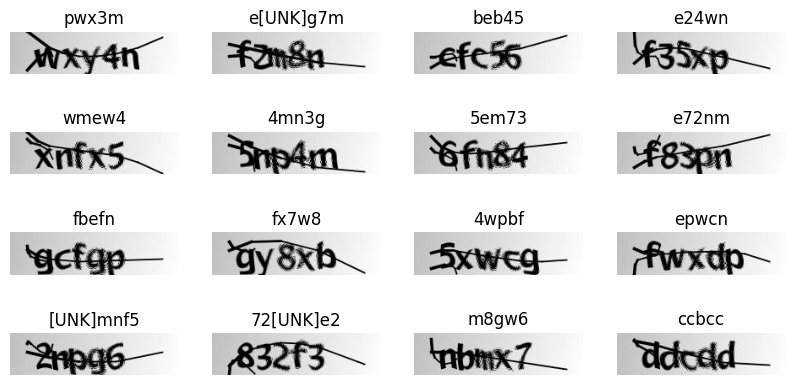

In [5]:
#tf.data.Dataset.from_tensor_slices: numpy array 또는 tensor로 부터 데이터 셋을 만듭니다.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map( # 위에서 정의한 함수를 적용합니다.
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size) # 배치 사이즈를 지정합니다.
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

#데이터 시각화 - Figure_1.png로 저장됨
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## 모델 생성


In [6]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # 모델이 training하는 경우, `self.add_loss()`를 사용하여 loss를 계산하고 더해줍니다.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # 테스트 시에는, 단지 예측 결과값만 반환합니다.
        return y_pred

def build_model():
# 모델 input 정의
    input_img = layers.Input(
    shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # 첫번째 conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # 두번째 conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # 우리는 두 번의 max pool(stride 2, pool size 2)을 사용할 것입니다.
    # 그러므로 feature maps는 4배 downsampled 됩니다.
    # 마지막 레이어의 필터의 갯수는 64개입니다
    # 모델의 RNN part에 넣기 전에 Reshape를 해줍시다.

    new_shape = ((img_width // downsample_factor), (img_height // downsample_factor) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # 위에서 제작한 CTC loss를 계산하는 CTC layer를 추가합시다.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # 모델 정의
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # 옵티마이저 정의
    opt = keras.optimizers.Adam()

    # 모델 컴파일
    model.compile(optimizer=opt)
    return model

# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

## 모델 학습

In [10]:
epochs = 100
early_stopping_patience = 10

# early_stopping 콜백 함수 선언
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# 모델 훈련하기
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
59/59 [==============================] - 5s 82ms/step - loss: 0.1975 - val_loss: 0.0363
Epoch 2/100
59/59 [==============================] - 5s 83ms/step - loss: 0.2129 - val_loss: 0.0391
Epoch 3/100
59/59 [==============================] - 5s 82ms/step - loss: 0.2126 - val_loss: 0.0379
Epoch 4/100
59/59 [==============================] - 5s 83ms/step - loss: 0.1657 - val_loss: 0.0260
Epoch 5/100
59/59 [==============================] - 5s 83ms/step - loss: 0.1214 - val_loss: 0.0235
Epoch 6/100
59/59 [==============================] - 5s 83ms/step - loss: 0.0995 - val_loss: 0.0338
Epoch 7/100
59/59 [==============================] - 5s 82ms/step - loss: 0.1411 - val_loss: 0.0276
Epoch 8/100
59/59 [==============================] - 5s 84ms/step - loss: 0.0794 - val_loss: 0.0109
Epoch 9/100
59/59 [==============================] - 5s 84ms/step - loss: 0.1240 - val_loss: 0.0228
Epoch 10/100
59/59 [==============================] - 5s 82ms/step - loss: 0.0874 - val_loss: 0.0565

## 예측


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            4921

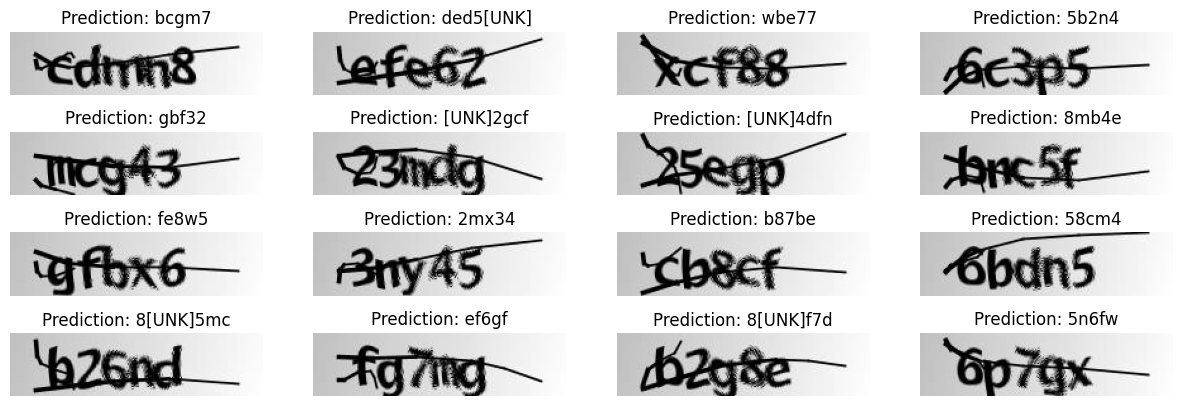

In [11]:
# Get the prediction model by extracting layers till the output layer
# 출력 레이어까지 레이어를 추출하여 예측 모델을 가져옵니다.
prediction_model = keras.models.Model(
    inputs=model.get_layer(name="image").input, outputs=model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

#  validation_dataset의 배치 1개를 시각화해봅시다.
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()